In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_dataset ,load_file
from utils.plot_utils import plot_targets
from utils.preprocessing import create_batch_sequences, create_sequences
from scipy.signal import find_peaks

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

In [2]:
root_dir = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"
sub_ids = [sub_id for sub_id in os.listdir(root_dir) if sub_id.startswith("sub-pp")]

In [3]:
ds = load_dataset(root_dir, sub_ids=sub_ids, tracked_points=["left_ankle", "right_ankle"], normalize=True)

Z:\Keep Control\Data\lab dataset\rawdata\sub-pp162\motion\sub-pp162_task-walkFast_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp162\motion\sub-pp162_task-walkPreferred_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp162\motion\sub-pp162_task-walkSlow_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp163\motion\sub-pp163_task-walkFast_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp163\motion\sub-pp163_task-walkPreferred_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\rawdata\sub-pp163\motion\sub-pp163_task-walkSlow_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
Z:\Keep Control\Data\lab dataset\raw

In [4]:
WIN_LEN = 400
STEP_LEN = 200
data, targets, list_filenames, list_filenames_examples = create_batch_sequences(ds, win_len=WIN_LEN, step_len=STEP_LEN)

In [5]:
print(f"Shape of data: {data.shape}")
for k in targets.keys():
    print(f"Shape of {k}: {targets[k].shape}")
print(f"Number of filenames: {len(list_filenames)}")

Shape of data: (2186, 400, 18)
Shape of initial_contact_left: (2186, 400, 1)
Shape of final_contact_left: (2186, 400, 1)
Shape of initial_contact_right: (2186, 400, 1)
Shape of final_contact_right: (2186, 400, 1)
Number of filenames: 2186


98: sub-pp011_task-walkSlow


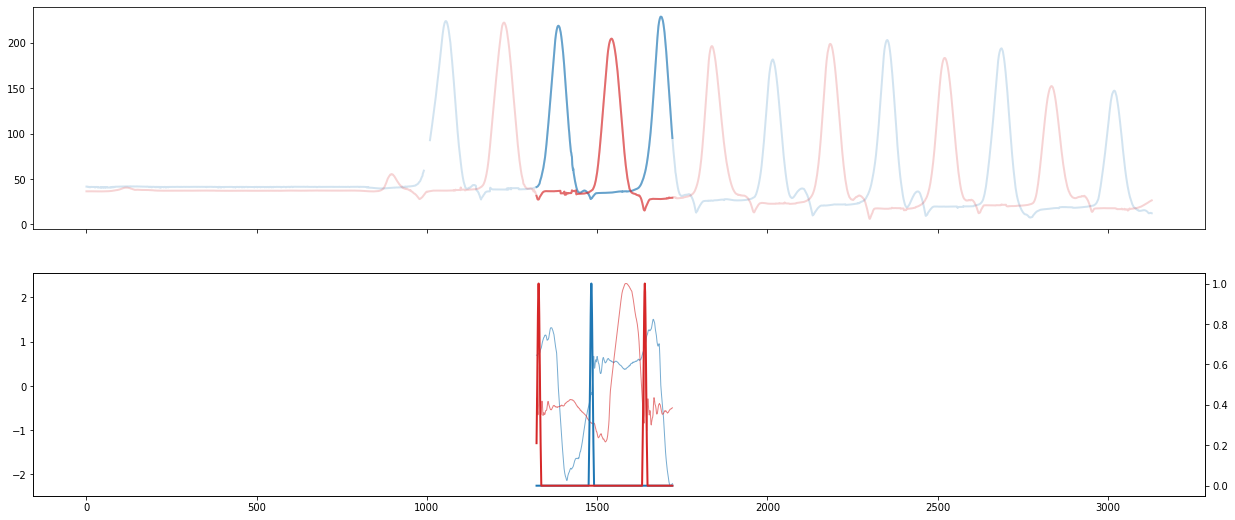

In [6]:
# Select a random example
ix_example = np.random.choice(data.shape[0], 1, replace=False)[0]
ix_window = ix_example - list_filenames.index(list_filenames[ix_example])

# Get filename prefix belonging to this example
filename_prefix = list_filenames[ix_example]
print(f"{ix_example:d}: {filename_prefix:s}")

# Read data
df_omc = pd.read_csv(os.path.join(root_dir, filename_prefix[:9], "motion", filename_prefix+"_tracksys-omc_motion.tsv"), sep="\t", header=0)
df_imu = pd.read_csv(os.path.join(root_dir, filename_prefix[:9], "motion", filename_prefix+"_tracksys-imu_motion.tsv"), sep="\t", header=0)
df_events = pd.read_csv(os.path.join(root_dir, filename_prefix[:9], "motion", filename_prefix+"_events.tsv"), sep="\t", header=0)
ix_start  = df_events[df_events["event_type"]=="start"]["onset"].values[0]
ix_end    = df_events[df_events["event_type"]=="stop"]["onset"].values[0]

# Plot figure
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(21, 9))
axs[0].plot(np.arange(len(df_omc)), df_omc["l_heel_POS_z"].iloc[:], c="tab:blue", alpha=0.2, lw=2)
axs[0].plot(np.arange(len(df_omc)), df_omc["r_heel_POS_z"].iloc[:], c="tab:red", alpha=0.2, lw=2)
axs[0].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), df_omc["l_heel_POS_z"].iloc[ix_start+ix_window*STEP_LEN:ix_start+ix_window*STEP_LEN+WIN_LEN], c="tab:blue", alpha=0.6, lw=2)
axs[0].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), df_omc["r_heel_POS_z"].iloc[ix_start+ix_window*STEP_LEN:ix_start+ix_window*STEP_LEN+WIN_LEN], c="tab:red", alpha=0.6, lw=2)

axs[1].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), data[ix_example][:,5], c="tab:blue", alpha=0.6, lw=1)
axs[1].plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), data[ix_example][:,14], c="tab:red", alpha=0.6, lw=1)
axs_ = axs[1].twinx()
axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_left"][ix_example][:,0], c="tab:blue", lw=2)
# axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_left"][ix_example][:,0], c="tab:blue", lw=2)
axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_right"][ix_example][:,0], c="tab:red", lw=2)
# axs_.plot(np.arange(ix_start+ix_window*STEP_LEN, ix_start+ix_window*STEP_LEN+WIN_LEN), targets["initial_contact_left"][ix_example][:,0], c="tab:blue", lw=2)
plt.show()


In [7]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary

In [14]:
def build_model(input_dim, target_classes):
    # Define layers
    inputs = keras.layers.Input(shape=(None, input_dim), name="inputs")
    tcn = TCN(nb_filters=16, kernel_size=5, nb_stacks=1, dilations=[1, 2], padding="same", use_skip_connections=True, use_batch_norm=True, return_sequences=True, name="tcn")(inputs)
    outputs = []
    for i in range(len(target_classes)):
        outputs.append(keras.layers.Dense(units=1, activation="sigmoid", name=target_classes[i])(tcn))
    
    # Instantiate model
    model = keras.models.Model(inputs=inputs, outputs=outputs, name="tcn_model")

    # Compile
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

In [15]:
model = build_model(data.shape[-1], target_classes=list(targets.keys()))
model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 18)]   0           []                               
                                                                                                  
 tcn (TCN)                      (None, None, 16)     5904        ['inputs[0][0]']                 
                                                                                                  
 initial_contact_left (Dense)   (None, None, 1)      17          ['tcn[0][0]']                    
                                                                                                  
 final_contact_left (Dense)     (None, None, 1)      17          ['tcn[0][0]']                    
                                                                                          

In [16]:
history = model.fit(x=data, y=targets, batch_size=8, epochs=5, validation_split=0.1)

Epoch 1/5
246/246 [==============================] - 10s 29ms/step - loss: 0.3305 - initial_contact_left_loss: 0.0806 - final_contact_left_loss: 0.0502 - initial_contact_right_loss: 0.1395 - final_contact_right_loss: 0.0602 - val_loss: 0.0798 - val_initial_contact_left_loss: 0.0234 - val_final_contact_left_loss: 0.0230 - val_initial_contact_right_loss: 0.0199 - val_final_contact_right_loss: 0.0135
Epoch 2/5
246/246 [==============================] - 6s 25ms/step - loss: 0.0508 - initial_contact_left_loss: 0.0133 - final_contact_left_loss: 0.0128 - initial_contact_right_loss: 0.0144 - final_contact_right_loss: 0.0103 - val_loss: 0.0374 - val_initial_contact_left_loss: 0.0111 - val_final_contact_left_loss: 0.0088 - val_initial_contact_right_loss: 0.0107 - val_final_contact_right_loss: 0.0068
Epoch 3/5
246/246 [==============================] - 7s 29ms/step - loss: 0.0379 - initial_contact_left_loss: 0.0100 - final_contact_left_loss: 0.0093 - initial_contact_right_loss: 0.0099 - final_con

In [17]:
predictions = model.predict(data, batch_size=16)

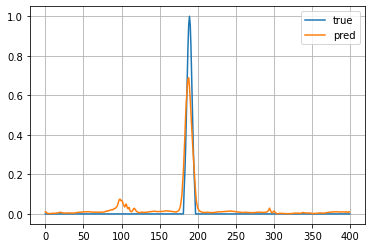

In [48]:
indx_example = np.random.choice(data.shape[0], 1, replace=False)[0]

plt.plot(targets["final_contact_right"][indx_example][:,0], label='true')
plt.plot(predictions[3][indx_example][:,0], label='pred')

plt.grid()
plt.legend()
plt.show()